In [1]:
#pip install -U albumentations

In [2]:
#pip install opencv-python

In [3]:
# Import libraries
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from brain_dataset import BrainDataset
from brain_dataset import set_seed, dataset_info, print_model_architecture
from unet_architecture import UNet
from attention_gate import AttentionUNet

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
# Cpu or Gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Load files

In [5]:
shutil.unpack_archive('input.zip')

In [6]:
BASE_PATH = 'lgg-mri-segmentation/kaggle_3m/'

mask_files = glob.glob(BASE_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

data_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

data_df

,image_path,mask_path,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,0
1,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,0
2,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,1
3,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,0
4,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19...,1
...,...,...,...
3924,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,1
3925,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,0
3926,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,1
3927,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19...,0


## Plotting the data

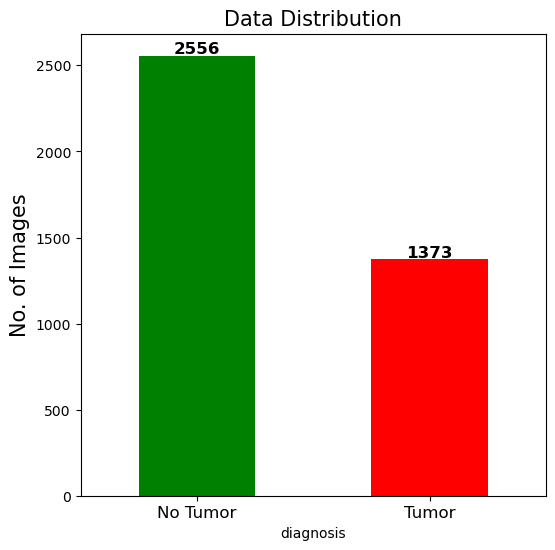

In [7]:
ax = data_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(data_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

## Split dataset

In [8]:
train_df, val_df = train_test_split(data_df, stratify=data_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


(-0.5, 1279.5, 255.5, -0.5)

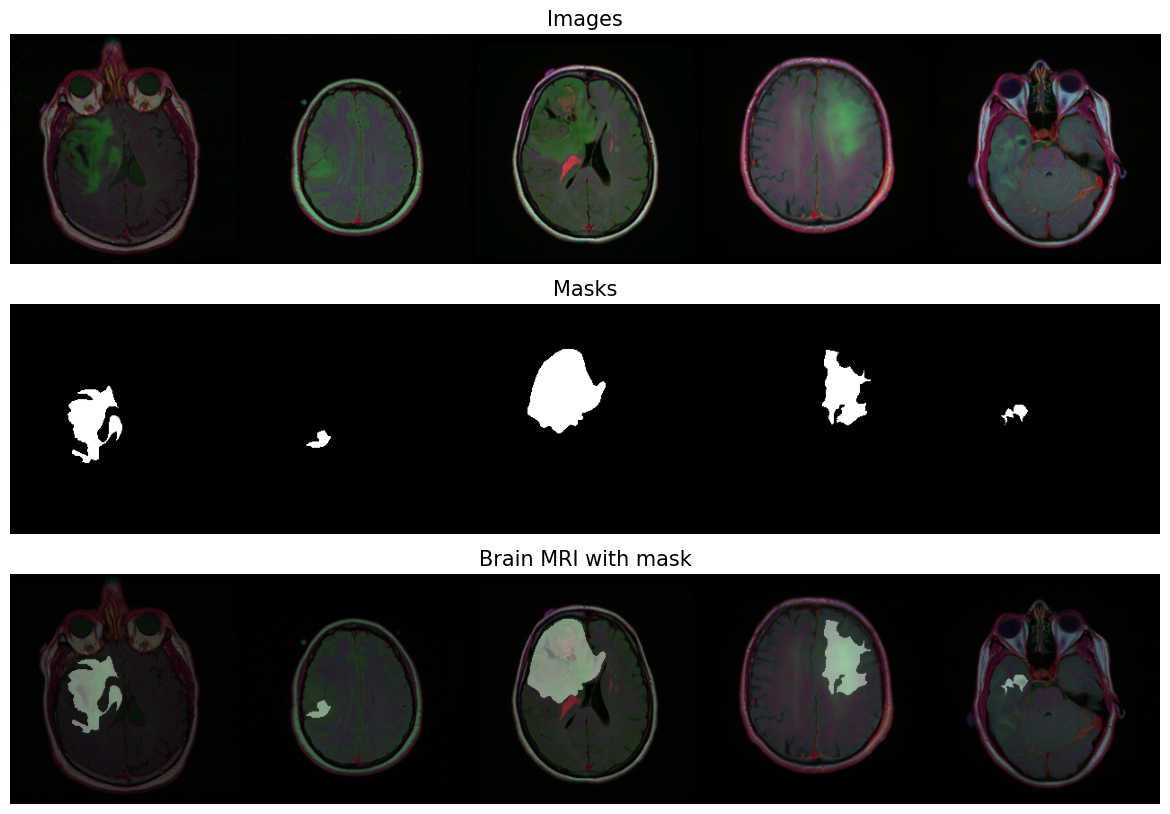

In [9]:
set_seed()

# Figure for images and masks for positive diagnosis
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

# Pytorch dataset format

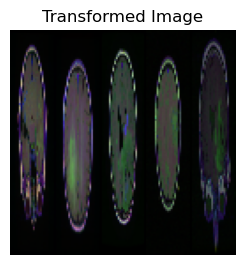

In [10]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

transformed_image = train_transform(image=images)['image']

# Plotting the transformed image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title('Transformed Image')
plt.axis('off')

plt.show()

In [11]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)


In [12]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



# Creating dataloaders

In [13]:
batch_size = 64

set_seed()
train_dataloader = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,  
                      pin_memory=True)  

set_seed()
val_dataloader = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

test_dataloader = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

In [14]:
images, masks = next(iter(train_dataloader))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


## Viewing samples from a batch

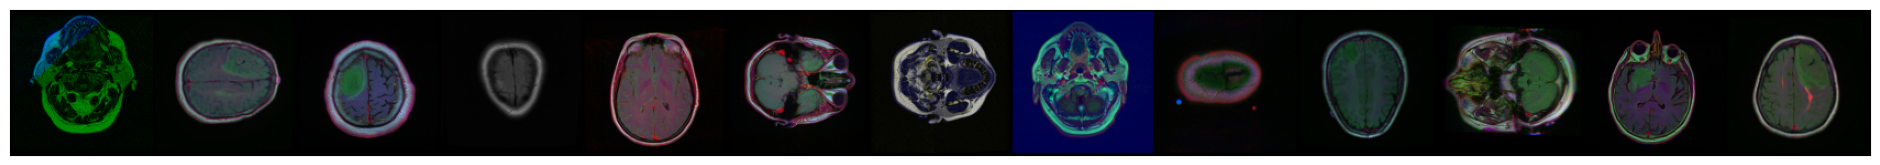

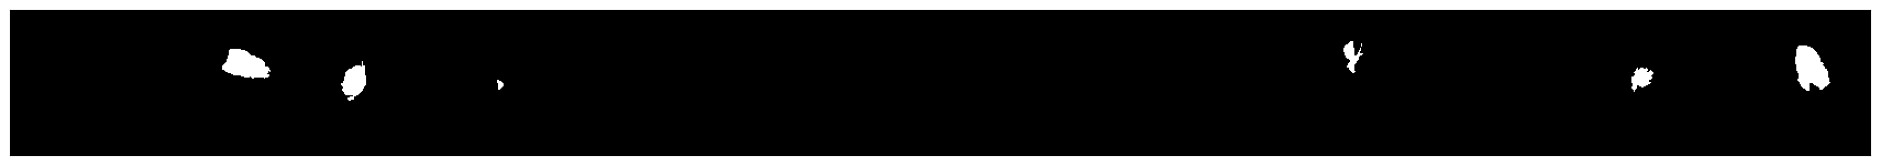

In [15]:
def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_dataloader)

# Metric & Loss functions

In [16]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

The Dice coefficient measures the similarity between two binary masks and is commonly used in image segmentation tasks.These functions are often used when training deep learning models for image segmentation tasks. During training, the model is optimized to minimize the combined loss (bce_dice_loss), which encourages both accurate pixel-wise predictions and accurate delineation of object boundaries. The dice_coef_metric function can be used to evaluate the model's performance during validation or testing by computing the Dice coefficient between predicted and ground truth masks.

# Training

In [33]:
def train_loop(model, loader, loss_func, optimizer, device, attn_bool):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image, mask = image.to(device), mask.to(device)
        
        optimizer.zero_grad()
        outputs = model(image)
        
        if attn_bool == 0:
            #UNET
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0 
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0 
    
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            loss = loss_func(outputs, mask)
            train_losses.append(loss.item())
            train_dices.append(dice)
            #Till här
        elif attn_bool == 1:
            #Attention gate
            outputs = torch.sigmoid(outputs)
            predicted_mask = (outputs >= 0.5).float()  
            loss = loss_func(outputs, mask)
            dice = dice_coef_metric(predicted_mask, mask)
            #Till här

        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_dices.append(dice.item())
        
        print(f'Batch [{i+1}/{len(loader)}], Loss: {loss.item()}, Dice Coefficient: {dice}')
        
    return train_dices, train_losses


The attention mechanism can produce attention maps or coefficients that are not necessarily bounded between 0 and 1. The values in these maps can be positive or negative, and they represent the importance or relevance of different spatial regions in the input feature maps.

The Dice coefficient is a statistical metric used to quantify the similarity or overlap between two sets or regions. 
A Dice coefficient of 0 indicates no overlap or dissimilarity between the predicted and ground truth masks.
A Dice coefficient of 1 indicates perfect overlap and complete similarity between the predicted and ground truth masks.

In [32]:
def eval_loop(model, loader, loss_func, device, attn_bool, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image, mask = image.to(device), mask.to(device)
            outputs = model(image)

            
            if attn_bool == 0:
                #UNET
                loss = loss_func(outputs, mask) 
                out_cut = np.copy(outputs.data.cpu().numpy())
                out_cut[np.nonzero(out_cut < 0.5)] = 0.0 
                out_cut[np.nonzero(out_cut >= 0.5)] = 1.0 
                dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
                #Til här
            elif attn_bool == 1:
                #Attention gate
                outputs = torch.sigmoid(outputs)
                predicted_mask = (outputs >= 0.5).float()  
                dice = dice_coef_metric(predicted_mask, mask)
                loss = loss_func(outputs, mask)  
                #Till här  
                      
            val_loss += loss.item()
            val_dice += dice.item()
            
            # Print batch information
            print(f'Validation Batch [{step+1}/{len(loader)}], Loss: {loss.item()}, Dice Coefficient: {dice.item()}')
        
        val_mean_dice = val_dice / (step + 1) 
        val_mean_loss = val_loss / (step + 1)  
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss


In [31]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs, device, attn_bool):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    
    for epoch in range(num_epochs):
        # Training
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer, device, attn_bool)
        
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        
        # Validation
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func, device, attn_bool)
        
        # Record history
        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)
        
        # Adjust learning rate if using a scheduler
        if scheduler is not None:
            scheduler.step(val_mean_dice)
        
        # Print epoch information
        print('Epoch: {}/{} | Train Loss: {:.3f} | Val Loss: {:.3f} | Train DICE: {:.3f} | Val DICE: {:.3f}'.format(
            epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice, val_mean_dice))
    
    return train_loss_history, train_dice_history, val_loss_history, val_dice_history


# UNet Model

In [21]:
# UNET Model
unet_model = UNet(3,1).to(device)
out = unet_model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


In [34]:
import itertools

"""Test för att se om allt funkar"""
# Define the number of batches to use for testing
num_test_batches = 2  # Adjust this to your desired number of batches
attn_bool = 0
# Create a subset of the data loader for testing
test_train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# Extract a smaller portion of the data loaders for testing and convert to a list
test_train_dl = list(itertools.islice(test_train_dl, num_test_batches))
test_val_dl = list(itertools.islice(test_val_dl, num_test_batches))

# Define your optimizer, scheduler, and number of epochs as before
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 5

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    unet_model, test_train_dl, test_val_dl, bce_dice_loss, optimizer, scheduler, num_epochs, device, attn_bool)

Training starts
Batch [1/2], Loss: 1.2687329053878784, Dice Coefficient: 0.21123260437375746
Batch [2/2], Loss: 1.2348005771636963, Dice Coefficient: 0.400013557483731
Validation Batch [1/2], Loss: 1.3853726387023926, Dice Coefficient: 0.08592728223907926
Validation Batch [2/2], Loss: 1.3732359409332275, Dice Coefficient: 0.12796281951975214
Epoch: 1/5 | Train Loss: 1.252 | Val Loss: 1.379 | Train DICE: 0.306 | Val DICE: 0.107
Batch [1/2], Loss: 1.2374435663223267, Dice Coefficient: 0.2968801007321737
Batch [2/2], Loss: 1.177314281463623, Dice Coefficient: 0.5036805710461745
Validation Batch [1/2], Loss: 9.474343299865723, Dice Coefficient: 0.010636897596969171
Validation Batch [2/2], Loss: 8.004807472229004, Dice Coefficient: 0.01613863778633144
Epoch: 2/5 | Train Loss: 1.207 | Val Loss: 8.740 | Train DICE: 0.400 | Val DICE: 0.013
Batch [1/2], Loss: 1.1941027641296387, Dice Coefficient: 0.46707761277668813
Batch [2/2], Loss: 1.1464059352874756, Dice Coefficient: 0.5440454662877809
Val

In [36]:
""" Träning"""
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 40
attn_bool = 0
print("Training starts")
u_train_loss_history, u_train_dice_history, u_val_loss_history, u_val_dice_history = train_model(
    unet_model, train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs, device, attn_bool)

Training starts
Batch [1/47], Loss: 1.1648130416870117, Dice Coefficient: 0.4956770139021139
Batch [2/47], Loss: 1.261288046836853, Dice Coefficient: 0.1138296755224194
Batch [3/47], Loss: 1.181147813796997, Dice Coefficient: 0.41683043234138123
Batch [4/47], Loss: 1.1155494451522827, Dice Coefficient: 0.5634732874041336
Batch [5/47], Loss: 1.1738513708114624, Dice Coefficient: 0.26329809725158565
Batch [6/47], Loss: 1.1548093557357788, Dice Coefficient: 0.37345138184389315
Batch [7/47], Loss: 1.1499143838882446, Dice Coefficient: 0.31983261096995963
Batch [8/47], Loss: 1.124794840812683, Dice Coefficient: 0.5598561759729273
Batch [9/47], Loss: 1.1146187782287598, Dice Coefficient: 0.5567928730512249
Batch [10/47], Loss: 1.0932533740997314, Dice Coefficient: 0.630730782488797
Batch [11/47], Loss: 1.0712820291519165, Dice Coefficient: 0.5515519461746695
Batch [12/47], Loss: 1.0877175331115723, Dice Coefficient: 0.4491800801027734
Batch [13/47], Loss: 1.1164904832839966, Dice Coefficient

KeyboardInterrupt: 

In [71]:
# save model values
torch.save({'model_state_dict': unet_model.state_dict(),
            'train_losses': u_train_loss_history,
            'train_dice': u_train_dice_history,
            'val_losses': u_val_loss_history,
            'val_dice': u_val_dice_history,
            'epochs': num_epochs,
            }, "./UNET_model.ckpt")

In [45]:
# load model values
unet_model = UNet(3, 1).to(device)
UNET_checkpoint = torch.load("UNET_model.ckpt")
unet_model.load_state_dict(UNET_checkpoint['model_state_dict'])

u_train_loss_history = UNET_checkpoint['train_losses']
u_train_dice_history = UNET_checkpoint['train_dice']
u_val_loss_history = UNET_checkpoint['val_losses']
u_val_dice_history = UNET_checkpoint['val_dice']
num_epochs = UNET_checkpoint['epochs']

## UNet results

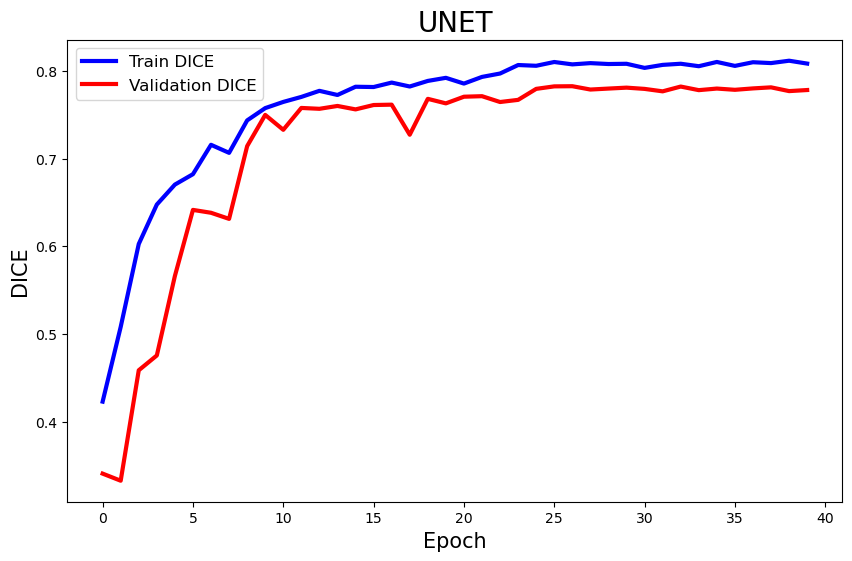

In [46]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('UNET', u_train_dice_history, u_val_dice_history, num_epochs)

A higher Dice coefficient indicates better agreement between the predicted and ground truth masks. In the context of image segmentation, you want the Dice coefficient to increase during training, as this means that the model's predictions are becoming more accurate and aligning better with the ground truth.

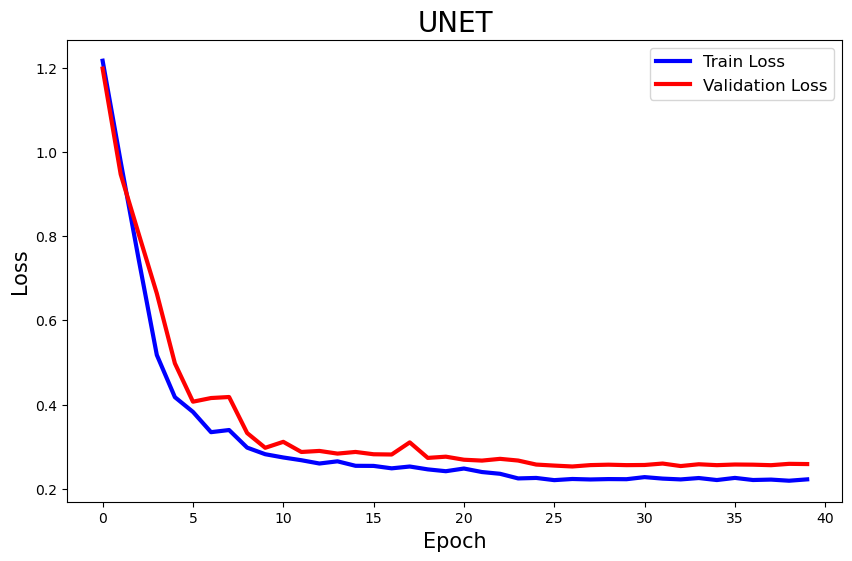

In [47]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()
    
plot_loss_history('UNET', u_train_loss_history, u_val_loss_history, num_epochs)

## UNet: Test on testset

In [48]:
# Evaluate the model on the test set
u_test_dice, u_test_loss = eval_loop(unet_model, test_dataloader, bce_dice_loss, device=device, attn_bool = 0, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100 * u_test_dice), u_test_loss))

Validation Batch [1/7], Loss: 0.16800303757190704, Dice Coefficient: 0.8585441042527849
Validation Batch [2/7], Loss: 0.2768169045448303, Dice Coefficient: 0.7656997131016895
Validation Batch [3/7], Loss: 0.21086442470550537, Dice Coefficient: 0.8192575196459218
Validation Batch [4/7], Loss: 0.1841564029455185, Dice Coefficient: 0.8433431331373372
Validation Batch [5/7], Loss: 0.25715628266334534, Dice Coefficient: 0.7744298712040647
Validation Batch [6/7], Loss: 0.258929044008255, Dice Coefficient: 0.7714489835682276
Validation Batch [7/7], Loss: 0.44021889567375183, Dice Coefficient: 0.6197183098591549
Mean IoU/DICE: 77.892%, Loss: 0.257


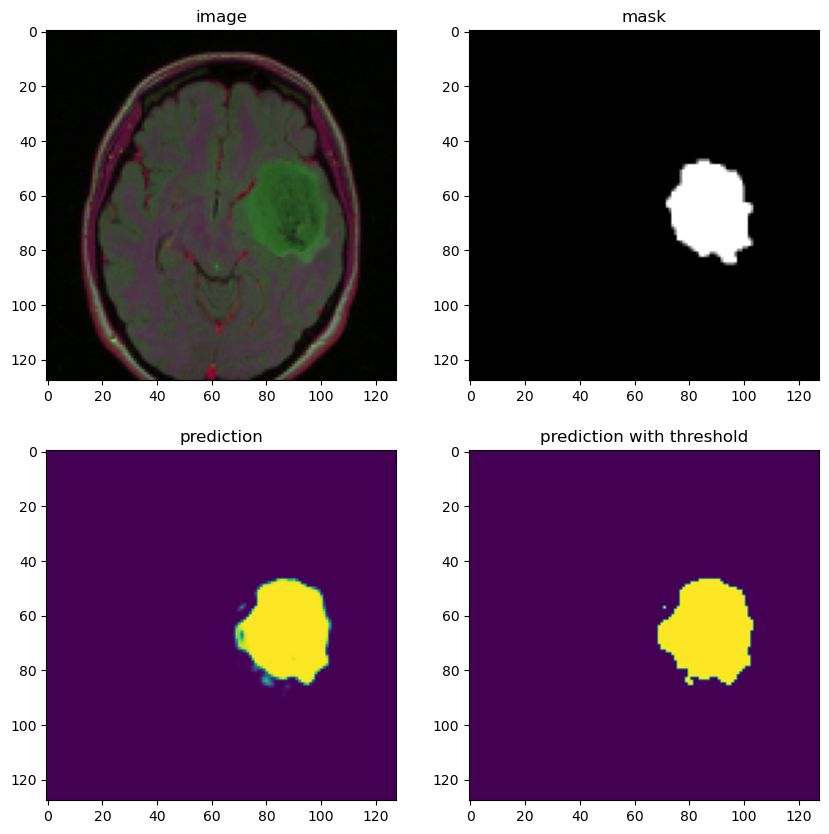

In [78]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Predicted 
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = unet_model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# Plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

# Attention Gate Model

In [38]:
attention_unet_model = AttentionUNet(n_classes=1).to(device)
output = torch.randn(1,3,256,256).to(device)
print(output.shape)

torch.Size([1, 3, 256, 256])


In [39]:
import itertools

"""Test för att se om allt funkar"""
# Define the number of batches to use for testing
num_test_batches = 2  
attn_bool = 1
# Create a subset of the data loader for testing
test_train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# Extract a smaller portion of the data loaders for testing and convert to a list
test_train_dl = list(itertools.islice(test_train_dl, num_test_batches))
test_val_dl = list(itertools.islice(test_val_dl, num_test_batches))

# Define your optimizer, scheduler, and number of epochs as before
optimizer = torch.optim.Adam(attention_unet_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 5

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    attention_unet_model, test_train_dl, test_val_dl, bce_dice_loss, optimizer, scheduler, num_epochs, device, attn_bool)

Training starts
Batch [1/2], Loss: 1.742408275604248, Dice Coefficient: 0.01964443176984787
Batch [2/2], Loss: 1.665637731552124, Dice Coefficient: 0.03959159925580025
Validation Batch [1/2], Loss: 1.654471755027771, Dice Coefficient: 0.0
Validation Batch [2/2], Loss: 1.649484395980835, Dice Coefficient: 0.0
Epoch: 1/5 | Train Loss: 1.704 | Val Loss: 1.652 | Train DICE: 0.030 | Val DICE: 0.000
Batch [1/2], Loss: 1.5816949605941772, Dice Coefficient: 0.03667590767145157
Batch [2/2], Loss: 1.4992101192474365, Dice Coefficient: 0.17796675860881805
Validation Batch [1/2], Loss: 9.348241806030273, Dice Coefficient: 0.010779711417853832
Validation Batch [2/2], Loss: 9.360575675964355, Dice Coefficient: 0.016350874677300453
Epoch: 2/5 | Train Loss: 1.540 | Val Loss: 9.354 | Train DICE: 0.107 | Val DICE: 0.014
Batch [1/2], Loss: 1.4466725587844849, Dice Coefficient: 0.015622023493051529
Batch [2/2], Loss: 1.402543067932129, Dice Coefficient: 0.0
Validation Batch [1/2], Loss: 63.66295623779297,

In [27]:
"""Träningen för Attention Gate"""""
optimizer = torch.optim.Adam(attention_unet_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs  = 40
attn_bool = 1
print("Training starts")
a_train_loss_history, a_train_dice_history, a_val_loss_history, a_val_dice_history = train_model(
    attention_unet_model, train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs, device, attn_bool)

Training starts
Batch [1/47], Loss: 0.9111339449882507, Dice Coefficient: 0.6379185318946838
Batch [2/47], Loss: 1.0273398160934448, Dice Coefficient: 0.28051814436912537
Batch [3/47], Loss: 0.947952389717102, Dice Coefficient: 0.4476979672908783
Batch [4/47], Loss: 0.9024463891983032, Dice Coefficient: 0.6592894196510315
Batch [5/47], Loss: 0.9229284524917603, Dice Coefficient: 0.6041666865348816
Batch [6/47], Loss: 0.9857718348503113, Dice Coefficient: 0.4074322581291199
Batch [7/47], Loss: 0.9694494605064392, Dice Coefficient: 0.38851693272590637
Batch [8/47], Loss: 0.9207921624183655, Dice Coefficient: 0.5206340551376343
Batch [9/47], Loss: 0.8843933343887329, Dice Coefficient: 0.5734038949012756
Batch [10/47], Loss: 0.9255990386009216, Dice Coefficient: 0.46380624175071716
Batch [11/47], Loss: 0.9601870775222778, Dice Coefficient: 0.41635292768478394
Batch [12/47], Loss: 0.8641297221183777, Dice Coefficient: 0.643444299697876
Batch [13/47], Loss: 0.8870888352394104, Dice Coefficie

In [29]:
torch.save({'model_state_dict': attention_unet_model.state_dict(),
            'train_losses': a_train_loss_history,
            'train_dice': a_train_dice_history,
            'val_losses': a_val_loss_history,
            'val_dice': a_val_dice_history,
            'epochs': num_epochs,
            }, "./attention_model.ckpt")

In [41]:
# Load attention model values
attention_unet_model = AttentionUNet(n_classes=1).to(device)
attn_checkpoint = torch.load("attention_model.ckpt")
attention_unet_model.load_state_dict(attn_checkpoint['model_state_dict'])
a_train_loss_history = attn_checkpoint['train_losses']
a_train_dice_history = attn_checkpoint['train_dice']
a_val_loss_history = attn_checkpoint['val_losses']
a_val_dice_history = attn_checkpoint['val_dice']
num_epochs = attn_checkpoint['epochs']

## Attention Gate results

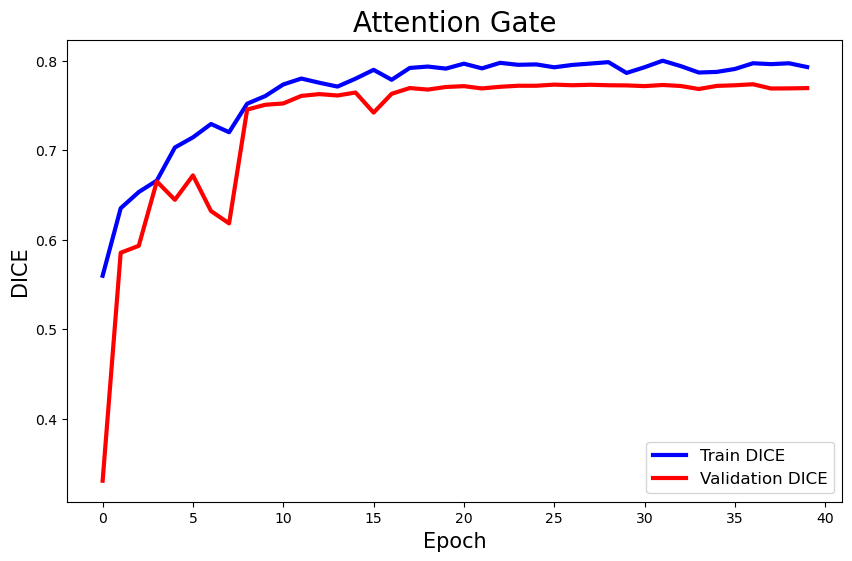

In [42]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('Attention Gate', a_train_dice_history, a_val_dice_history, num_epochs)

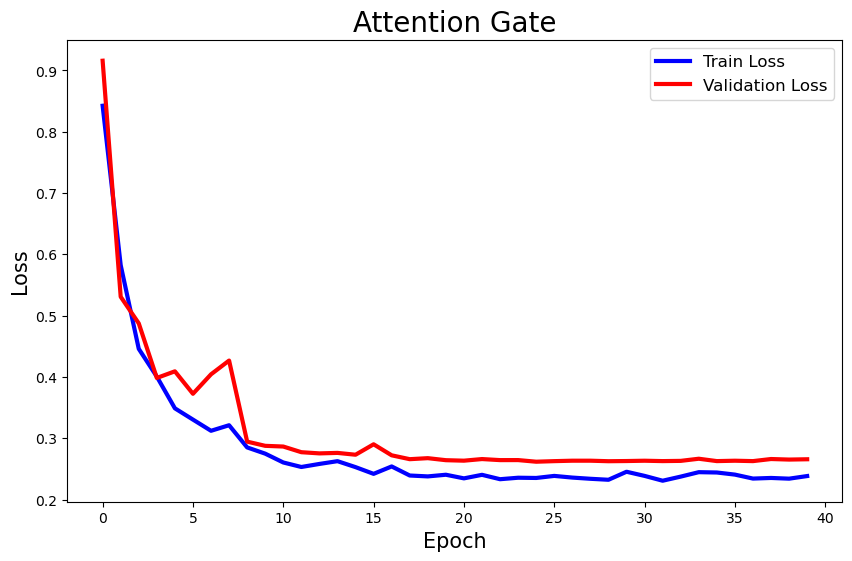

In [43]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()
    
plot_loss_history('Attention Gate', a_train_loss_history, a_val_loss_history, num_epochs)

## Attention gate test

In [44]:
# Evaluate the model on the test set
a_test_dice, a_test_loss = eval_loop(attention_unet_model, test_dataloader, bce_dice_loss, device=device, attn_bool = 1, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100 * a_test_dice), a_test_loss))


Validation Batch [1/7], Loss: 0.16711066663265228, Dice Coefficient: 0.8583804965019226
Validation Batch [2/7], Loss: 0.31603196263313293, Dice Coefficient: 0.7343142032623291
Validation Batch [3/7], Loss: 0.19928884506225586, Dice Coefficient: 0.8289393782615662
Validation Batch [4/7], Loss: 0.21213343739509583, Dice Coefficient: 0.8143303394317627
Validation Batch [5/7], Loss: 0.27625682950019836, Dice Coefficient: 0.7576605081558228
Validation Batch [6/7], Loss: 0.2389124035835266, Dice Coefficient: 0.7888996601104736
Validation Batch [7/7], Loss: 0.45323628187179565, Dice Coefficient: 0.5981873273849487
Mean IoU/DICE: 76.867%, Loss: 0.266


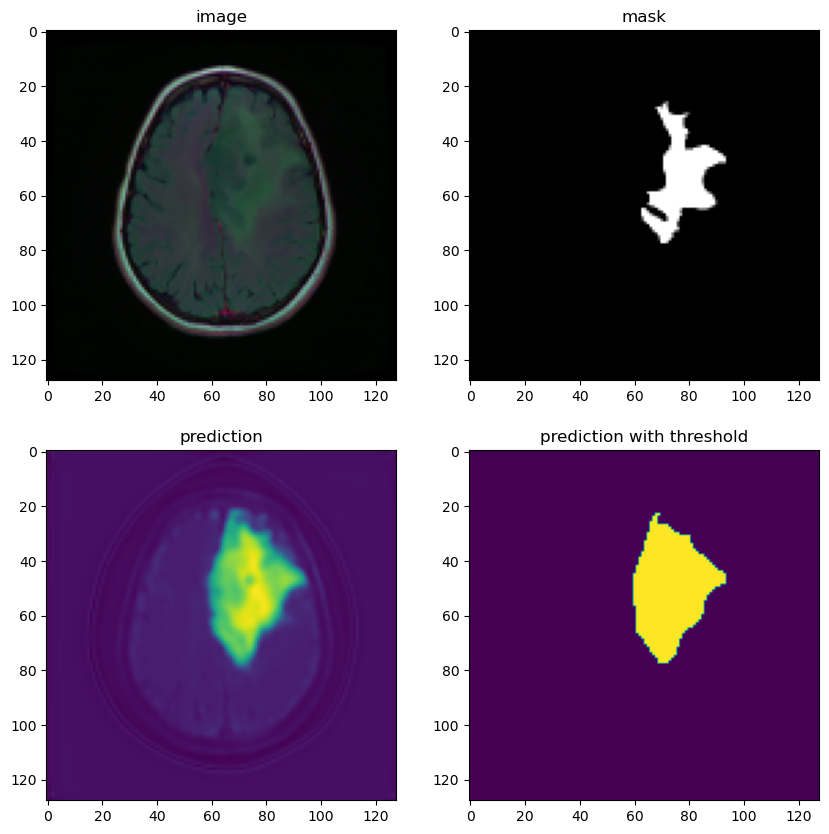

In [36]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Predicted
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = attention_unet_model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# Plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()